## Part 2a: generate disv properties

In [1]:
import sys, json, os ## Org
import rasterio, flopy ## Org
import numpy as np ## Org
import matplotlib.pyplot as plt ## Org
import geopandas as gpd ## Org
from mf6Voronoi.meshProperties import meshShape ## Org
from shapely.geometry import MultiLineString ## Org
from mf6Voronoi.tools.cellWork import getLayCellElevTupleFromRaster, getLayCellElevTupleFromElev

In [2]:
# open the json file
with open('json/disvDict.json') as file: ## Org
    gridProps = json.load(file) ## Org

In [3]:
cell2d = gridProps['cell2d']           #cellid, cell centroid xy, vertex number and vertex id list
vertices = gridProps['vertices']       #vertex id and xy coordinates
ncpl = gridProps['ncpl']               #number of cells per layer
nvert = gridProps['nvert']             #number of verts
centroids=gridProps['centroids']       #cell centroids xy 

## Part 2b: Model construction and simulation

In [ ]:
#Extract dem values for each centroid of the voronois
src = rasterio.open('rst/elevWgs18S.tif')  ## Org
elevation=[x for x in src.sample(centroids)] ## Org

In [ ]:
nlay = 15 ## Org

mtop=np.array([elev[0] for i,elev in enumerate(elevation)]) ## Org
zbot=np.zeros((nlay,ncpl)) ## Org


AcuifInf_Bottom = 3200 ## Org
zbot[0,] = AcuifInf_Bottom + (0.975 * (mtop - AcuifInf_Bottom)) ## Org
zbot[1,] = AcuifInf_Bottom + (0.95 * (mtop - AcuifInf_Bottom)) ## Org
zbot[2,] = AcuifInf_Bottom + (0.925 * (mtop - AcuifInf_Bottom)) ## Org
zbot[3,] = AcuifInf_Bottom + (0.9 * (mtop - AcuifInf_Bottom)) ## Org
zbot[4,] = AcuifInf_Bottom + (0.875 * (mtop - AcuifInf_Bottom)) ## Org
zbot[5,] = AcuifInf_Bottom + (0.85 * (mtop - AcuifInf_Bottom)) ## Org
zbot[6,] = AcuifInf_Bottom + (0.825 * (mtop - AcuifInf_Bottom)) ## Org
zbot[7,] = AcuifInf_Bottom + (0.8 * (mtop - AcuifInf_Bottom)) ## Org
zbot[8,] = AcuifInf_Bottom + (0.775 * (mtop - AcuifInf_Bottom)) ## Org
zbot[9,] = AcuifInf_Bottom + (0.75 * (mtop - AcuifInf_Bottom)) ## Org
zbot[10,] = AcuifInf_Bottom + (0.725 * (mtop - AcuifInf_Bottom)) ## Org
zbot[11,] = AcuifInf_Bottom + (0.7 * (mtop - AcuifInf_Bottom)) ## Org
zbot[12,] = AcuifInf_Bottom + (0.675 * (mtop - AcuifInf_Bottom)) ## Org
zbot[13,] = AcuifInf_Bottom + (0.40 * (mtop - AcuifInf_Bottom)) ## Org
zbot[14,] = AcuifInf_Bottom ## Org

### Create simulation and model

In [6]:
# create simulation
simName = 'mf6Sim' ## Org
modelName = 'mf6Model' ## Org
modelWs = 'modelFiles' ## Org
sim = flopy.mf6.MFSimulation(sim_name=modelName, version='mf6', ## Org
                             exe_name='bin/mf6.exe', ## Org
                             sim_ws=modelWs) ## Org

In [ ]:
# create tdis package
tdis_rc = [(1.0, 1, 1.0)] + [(86400*365, 1, 1.0) for level in range(5)] ## Org
print(tdis_rc[:3]) ## Org

tdis = flopy.mf6.ModflowTdis(sim, pname='tdis', time_units='SECONDS', ## Org
                             perioddata=tdis_rc, ## Org
                            nper=6) ## Org
 

[(1.0, 1, 1.0), (31536000, 1, 1.0), (31536000, 1, 1.0), (31536000, 1, 1.0), (31536000, 1, 1.0), (31536000, 1, 1.0)]


In [8]:
# create gwf model
gwf = flopy.mf6.ModflowGwf(sim, ## Org
                           modelname=modelName, ## Org
                           save_flows=True, ## Org
                           newtonoptions="NEWTON UNDER_RELAXATION") ## Org

In [ ]:
# create iterative model solution and register the gwf model with it
ims = flopy.mf6.ModflowIms(sim, ## Org
                           complexity='COMPLEX', ## Org
                           outer_maximum=150, ## Org
                           inner_maximum=50, ## Org
                           outer_dvclose=0.1, ## Org
                           inner_dvclose=0.0001, ## Org
                           backtracking_number=20, ## Org
                           linear_acceleration='BICGSTAB') ## Org
sim.register_ims_package(ims,[modelName]) ## Org

In [10]:
# disv
disv = flopy.mf6.ModflowGwfdisv(gwf, nlay=nlay, ncpl=ncpl, ## Org
                                top=mtop, botm=zbot, ## Org
                                nvert=nvert, vertices=vertices, ## Org
                                cell2d=cell2d) ## Org

<AxesSubplot: title={'center': 'top'}>

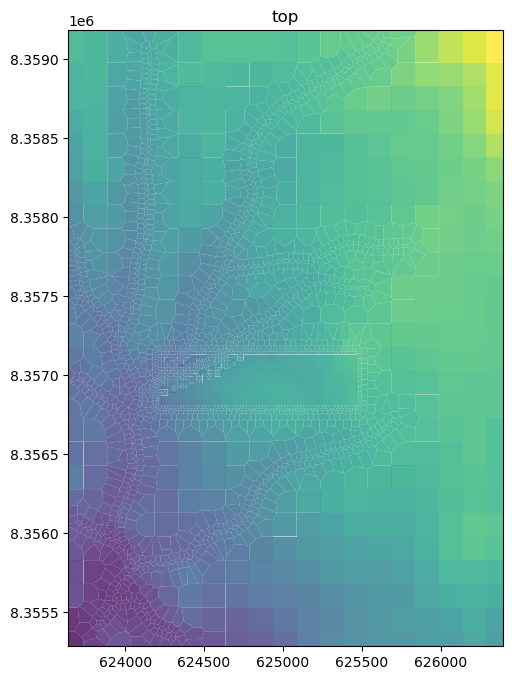

In [ ]:
disv.top.plot(figsize=(12,8), alpha=0.8) ## Org

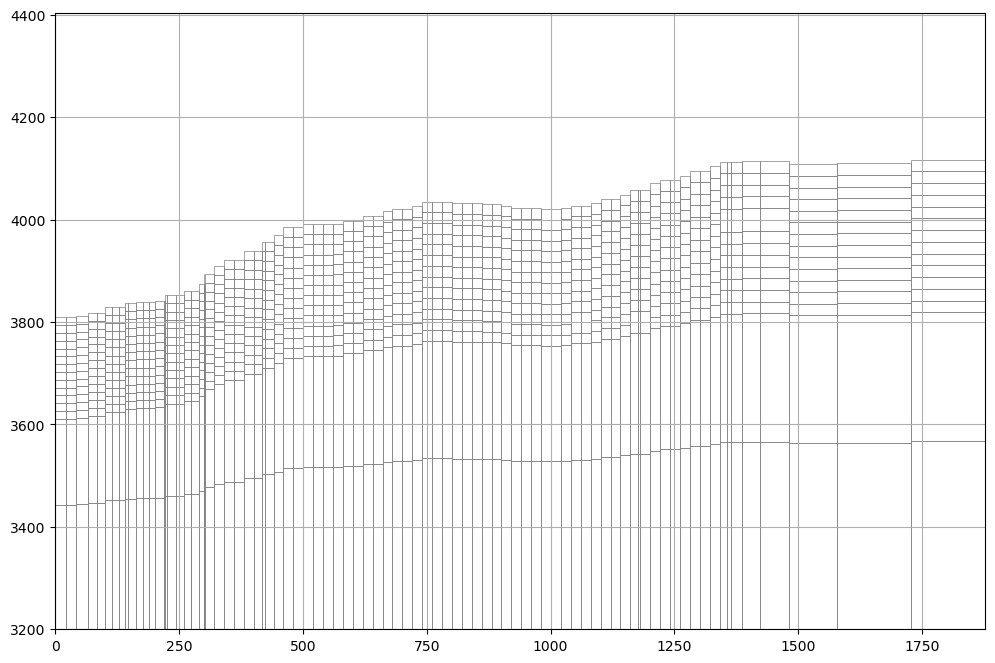

In [ ]:
crossSection = gpd.read_file('shp/crossSection.shp') ## Org
sectionLine =list(crossSection.iloc[0].geometry.coords) ## Org

fig, ax = plt.subplots(figsize=(12,8)) ## Org
modelxsect = flopy.plot.PlotCrossSection(model=gwf, line={'Line': sectionLine}) ## Org
linecollection = modelxsect.plot_grid(lw=0.5) ## Org
ax.grid() ## Org

In [ ]:
# initial conditions

ic = flopy.mf6.ModflowGwfic(gwf, strt=np.stack([mtop for i in range(nlay)])) ## Org
#headsInitial = np.load('npy/headCalibInitial.npy')
#ic = flopy.mf6.ModflowGwfic(gwf, strt=headsInitial)

In [ ]:
Kx =[4E-4] + [7E-7 for x in range(4)] + [3E-7 for x in range(4)] + [1E-7 for x in range(nlay - 9)] ## Org
icelltype = [1 for x in range(10)] + [0 for x in range(nlay - 10)] ## Org

# node property flow
npf = flopy.mf6.ModflowGwfnpf(gwf, ## Org
                              save_specific_discharge=True, ## Org
                              icelltype=icelltype, ## Org
                              k=Kx, ## Org
                              k33=np.array(Kx)/10) ## Org

In [ ]:
# define storage and transient stress periods
sto = flopy.mf6.ModflowGwfsto(gwf, ## Org
                              iconvert=1, ## Org
                              steady_state={ ## Org
                                0:True, ## Org
                              },
                              transient={
                                  1:True, ## Org
                                  2:True, ## Org
                                  3:True, ## Org
                                  4:True, ## Org
                                  5:True, ## Org
                              },
                              ss=1e-06,
                              sy=0.001,
                              ) ## Org

#### Working with rechage, evapotranspiration

In [ ]:
rchr = 0.2/365/86400 ## Org
rch = flopy.mf6.ModflowGwfrcha(gwf, recharge=rchr) ## Org
evtr = 1.2/365/86400 ## Org
evt = flopy.mf6.ModflowGwfevta(gwf,ievt=1,surface=mtop,rate=evtr,depth=1.0) ## Org

### Definition of the intersect object
For the manipulation of spatial data to determine hydraulic parameters or boundary conditions

In [18]:
# Define intersection object
interIx = flopy.utils.gridintersect.GridIntersect(gwf.modelgrid) ## Org

In [ ]:
#river package
layCellTupleList, cellElevList = getLayCellElevTupleFromRaster(gwf,interIx,'rst/elevWgs18S.tif','shp/riversSpart.shp') ## Org
riverSpd = {} ## Org
riverSpd[0] = [] ## Org
for index, layCellTuple in enumerate(layCellTupleList): ## Org
    riverSpd[0].append([layCellTuple,cellElevList[index],0.01]) ## Org

In [ ]:
riv = flopy.mf6.ModflowGwfdrn(gwf, stress_period_data=riverSpd) ## Org

[<AxesSubplot: title={'center': ' drn_0 location stress period 2 layer 1'}>]

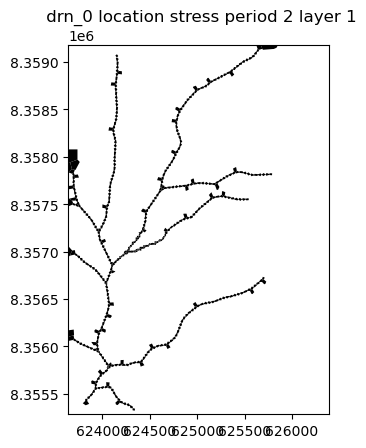

In [ ]:
#river plot
riv.plot(mflay=0, kper=1) ## Org

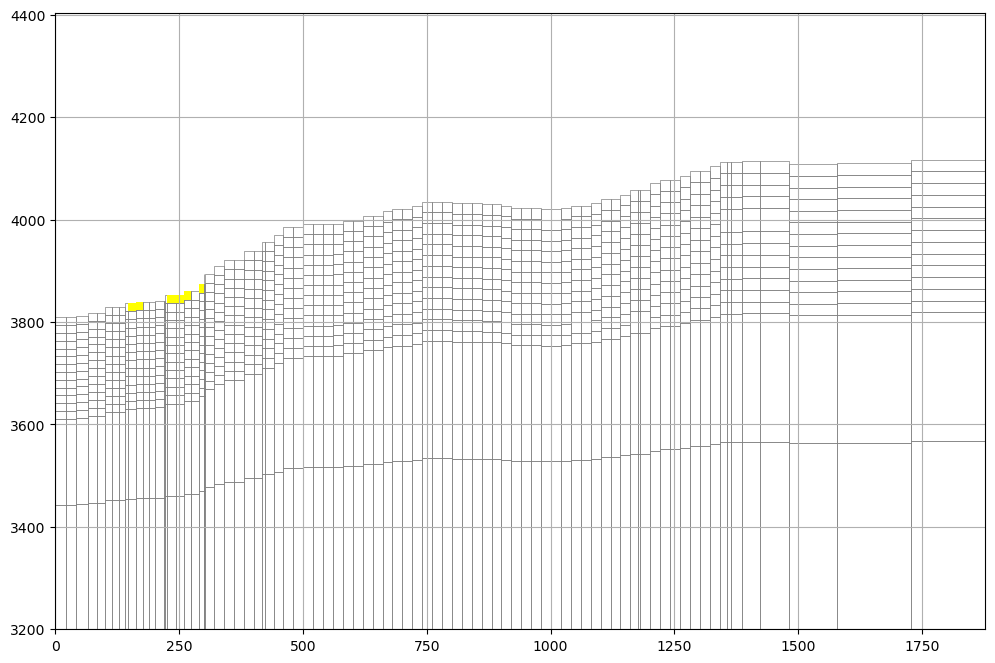

In [ ]:
crossSection = gpd.read_file('shp/crossSection.shp') ## Org
sectionLine =list(crossSection.iloc[0].geometry.coords) ## Org

fig, ax = plt.subplots(figsize=(12,8)) ## Org
xsect = flopy.plot.PlotCrossSection(model=gwf, line={'Line': sectionLine}) ## Org
lc = xsect.plot_grid(lw=0.5) ## Org
xsect.plot_bc('DRN',kper=4) ## Org
ax.grid() ## Org

### Set the Output Control and run simulation

In [24]:
#oc
head_filerecord = f"{gwf.name}.hds" ## Org
oc = flopy.mf6.ModflowGwfoc(gwf, ## Org
                            head_filerecord=head_filerecord, ## Org
                            saverecord=[("HEAD", "LAST")]) ## Org

In [25]:
# Run the simulation
sim.write_simulation() ## Org
success, buff = sim.run_simulation() ## Org

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model mf6Model...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package rcha_0...
    writing package evta_0...
    writing package drn_0...
INFORMATION: maxbound in ('gwf6', 'drn', 'dimensions') changed to 481 based on size of stress_period_data
    writing package oc...
FloPy is using the following executable to run the model: ../bin/mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.6.0 12/20/2024

   MODFLOW 6 compiled Dec 31 2024 17:10:16 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for rel

### Model output visualization

In [ ]:
headObj = gwf.output.head() ## Org
headObj.get_kstpkper() ## Org

In [ ]:
kper = 1 ## Org
lay = 0 ## Org

In [ ]:
heads = headObj.get_data(kstpkper=(0,kper)) 
#heads[lay,0,:5] 
#heads = headObj.get_data(kstpkper=(0,0)) 
#np.save('npy/headCalibInitial', heads)

In [ ]:
### Plot the heads for a defined layer and boundary conditions
fig = plt.figure(figsize=(12,8)) ## Org
ax = fig.add_subplot(1, 1, 1, aspect='equal') ## Org
modelmap = flopy.plot.PlotMapView(model=gwf) ## Org

####
levels = np.linspace(heads[heads>-1e+30].min(),heads[heads>-1e+30].max(),num=50) ## Org
contour = modelmap.contour_array(heads[lay],ax=ax,levels=levels,cmap='PuBu') 
ax.clabel(contour) ## Org


quadmesh = modelmap.plot_bc('DRN') ## Org
cellhead = modelmap.plot_array(heads[lay],ax=ax, cmap='Blues', alpha=0.8) 

linecollection = modelmap.plot_grid(linewidth=0.3, alpha=0.5, color='cyan', ax=ax) ## Org

plt.colorbar(cellhead, shrink=0.75) ## Org

plt.show() ## Org

In [ ]:
crossSection = gpd.read_file('shp/crossSection.shp')
sectionLine =list(crossSection.iloc[0].geometry.coords)

waterTable = flopy.utils.postprocessing.get_water_table(heads)
waterTable2 = flopy.utils.postprocessing.get_water_table(heads2)

fig, ax = plt.subplots(figsize=(12,8))
xsect = flopy.plot.PlotCrossSection(model=gwf, line={'Line': sectionLine})
lc = modelxsect.plot_grid(lw=0.5)
xsect.plot_array(heads, alpha=0.5)
xsect.plot_surface(waterTable)
xsect.plot_bc('drn', kper=kper, facecolor='none', edgecolor='teal')
plt.show()